Measure the inference time of a separate detector and recognition network.

In [1]:
from tqdm.notebook import tqdm
from itertools import product
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.resnet import resnet50
from random import shuffle
from joint_vs_separate_models import time_separate_det_recog_nets, time_joint_det_recog
import pandas as pd


def get_timing_results(
    faster_rcnn,
    rn50,
    recog_head,
    devices,
    det_input_sizes,
    recog_input_sizes,
    dets_per_imgs,
    iters
):
    results = []

    iter_list = list(product(
        det_input_sizes,
        recog_input_sizes,
        dets_per_imgs
    ))

    for device in tqdm(devices):
        for _ in tqdm(range(iters), leave=False):
            # Shuffle to avoid that a certain combination of params
            # always occurs at the same iteration.
            shuffle(iter_list)

            for (det_input_size,
                 recog_input_size,
                 dets_per_img) in tqdm(iter_list, leave=False):
                t_sep = time_separate_det_recog_nets(
                    faster_rcnn, rn50, device,
                    det_input_size=det_input_size,
                    recog_input_size=recog_input_size,
                    dets_per_img=dets_per_img,
                )
                results.append({
                    'Time (s)': t,
                    'Architecture': 'Separate',
                    'Input size': det_input_size,
                    'Input size (recog)': recog_input_size,
                    'Number of products': dets_per_img,
                    'Device': device.type,
                })
    return pd.DataFrame(results)

In [2]:
import torch
from pathlib import Path

from torch import nn


LAZY = True

df_res_path = Path('separate_inference_time_results.pkl')

devices = [
    torch.device('cuda'),
    torch.device('cpu')
]
rn50 = resnet50().eval()
faster_rcnn = fasterrcnn_resnet50_fpn(
    rpn_nms_thresh=1.0,
    box_score_thresh=0.0,
    box_nms_thresh=1.0,
).eval()

id_embedding_size = 512
recog_head = nn.Linear(
    faster_rcnn.roi_heads.box_predictor.cls_score.in_features,
    id_embedding_size
).eval()

In [3]:
if not df_res_path.exists() or not LAZY:
    df_res = get_timing_results(
        faster_rcnn, rn50, recog_head, devices=devices,
        det_input_sizes=[800],
        recog_input_sizes=[224],
        dets_per_imgs=list(range(10, 201, 10)),
        iters=5
    )
    df_res.to_pickle(df_res_path)
else:
    df_res = pd.read_pickle(df_res_path)

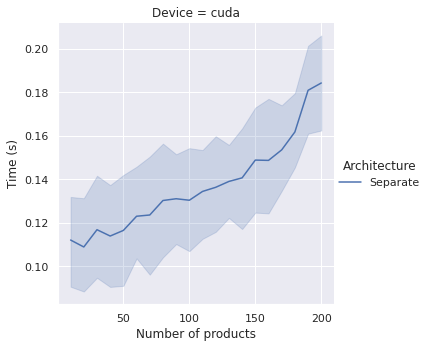

In [4]:
import seaborn as sns
sns.set()

N_PROD = 'Number of products'
TIME = 'Time (s)'
DEVICE = 'Device'
MODEL_TYPE = 'Architecture'

df_res_cuda = df_res[df_res[DEVICE] == 'cuda']
df_res_cpu = df_res[df_res[DEVICE] == 'cpu']

sns.relplot(data=df_res_cuda,
            x=N_PROD, y=TIME,
            hue=MODEL_TYPE, kind='line', style=MODEL_TYPE, col=DEVICE)

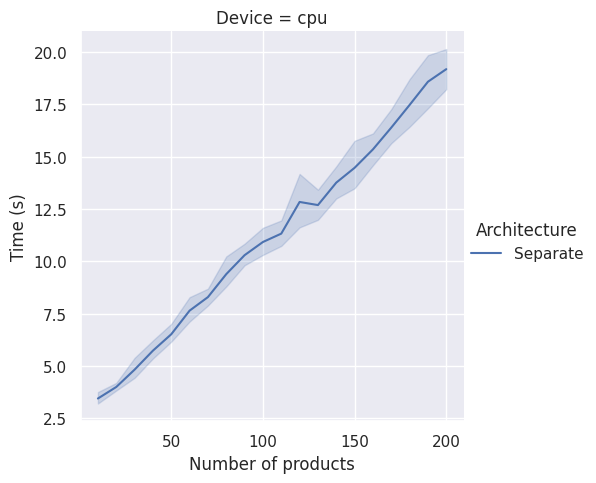

In [5]:
sns.relplot(data=df_res_cpu,
            x=N_PROD, y=TIME,
            hue=MODEL_TYPE, kind='line', style=MODEL_TYPE, col=DEVICE)